In [1]:
!pip install -q -q -q geopandas
!pip install -q -q -q btbpy
!pip install -q -q -q descartes
!pip install -q -q -q mapclassify

In this notebook, we illustrate the Geographicaly Weighted Fractal Analysis on the population distibution in France. 

In [26]:
import numpy as np
import pandas as pd

import geopandas as gpd
import btbpy
from shapely.geometry import Polygon
from pyproj import Transformer, transform

import os

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KDTree
from sklearn.neighbors import RadiusNeighborsRegressor

Filosofi2015_french_grid is a population-grid dataset. Each row represents a grid cell which the side is 200 m. Ind is the number of people in each cell.

In [3]:
df = pd.read_csv('Filosofi2015_french_grid.zip', compression='zip')
df.head(3)

,x,y,Ind,Men,Men_pauv
0,3763200,2893400,2818.5,990.0,280.0
1,3762200,2890000,1543.5,926.0,128.0
2,3762400,2893400,1338.0,508.0,131.0


First of all, we have to compute the neigbhor near each point for a range of radius. To do that, we use a kdtree.

In [9]:
def neighbors_near_point(df, weight, list_of_radius):
    neighbors = np.zeros([df.shape[0],list_of_radius.size],dtype=np.float)
    for i, r in enumerate(list_of_radius):
        tree = KDTree(df[['x', 'y']]) 
        neigh = RadiusNeighborsRegressor(radius=r)
        neigh.fit(df[['x', 'y']],  df.Ind)
        neighbors[:,i] = tree.query_radius(df[['x', 'y']], r= r, count_only=True) * neigh.predict(df[['x', 'y']])
    result = pd.DataFrame(neighbors)
    result.columns = [str(t) for t in list_of_radius]
    return(pd.concat([df[['x', 'y', weight]], result], axis=1))

In [11]:
list_of_radius = np.array([400, 800, 1600, 3200])
neighbors = neighbors_near_point(df, 'Ind', list_of_radius)

We reproject the neighbor from the european projection to the french projection :

In [51]:
transformer = Transformer.from_crs(3035, 2154)
neighbors.x, neighbors.y= transformer.transform(neighbors.y.values, neighbors.x.values)

Then we have just to smooth the neighbors to obtain the scale function. 

In [52]:
chem_data_dir = os.path.join(os.path.dirname(btbpy.__file__),'data')
chem_data_grid = os.path.join(chem_data_dir, 'fr_metro_grid1km.csv')
fr_1km = pd.read_csv(chem_data_grid)
scale_function = btbpy.kernelSmoothing(neighbors, '2154', 1000, 20000, fr_1km, verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


The correlation dimension is the slope of the curves of the log(scale fonction) versus log(radius).

In [53]:
scale_function['D_2'] = scale_function[list_of_radius.astype(str)].apply(lambda x :LinearRegression().fit(np.log(list_of_radius).reshape(list_of_radius.size,1), np.log(x)).coef_[0] ,   axis=1 ) 

We can display the map of the correlation dimension.

(42350.0, 1299650.0, 5996450.0, 7163550.0)

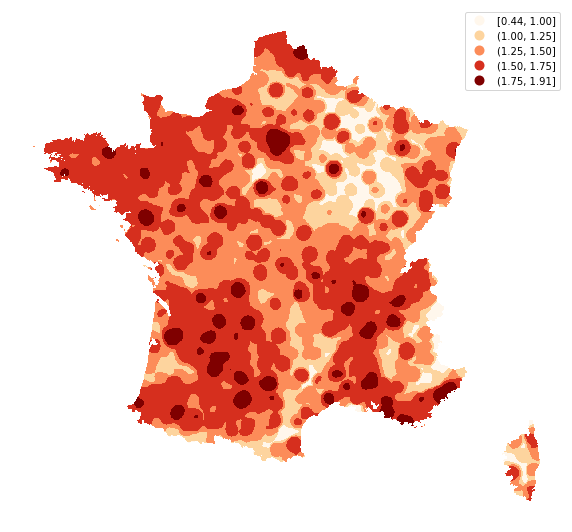

In [54]:
bins = [1, 1.25, 1.5, 1.75]
ax = scale_function.plot('D_2', scheme = 'User_Defined', classification_kwds={'bins':bins}, figsize=(10,10), legend=True, cmap='OrRd')
ax.axis(False)

We can also compute the Box-counting dimension D0. To do that, we have to transform the neighbor.

In [55]:
neighbors_0 = neighbors.copy()
neighbors_0[list_of_radius.astype(str)] = neighbors_0[list_of_radius.astype(str)]**(-1) 
scale_function_0 = btbpy.kernelSmoothing(neighbors_0, '3035', 1000, 20000, fr_1km, verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Be carreful, the box-counting dimension is not the directely the slop but the opposite. 

In [57]:
scale_function_0['D_0'] = scale_function_0[list_of_radius.astype(str)].apply(lambda x :-LinearRegression().fit(np.log(list_of_radius).reshape(list_of_radius.size,1), np.log(x)).coef_[0] ,   axis=1 ) 

(42350.0, 1299650.0, 5996450.0, 7163550.0)

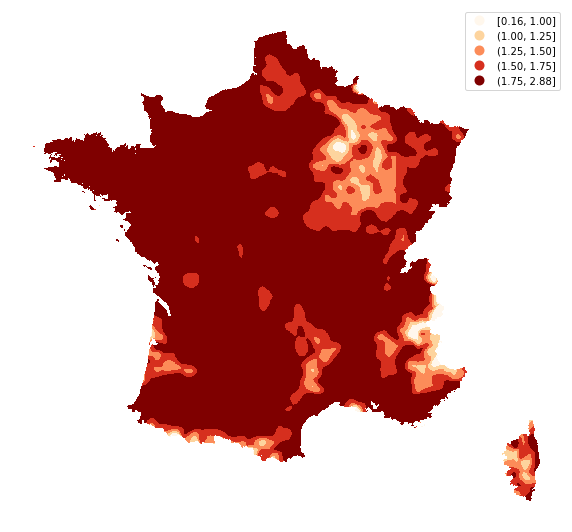

In [58]:
bins = [1, 1.25, 1.5, 1.75]
ax = scale_function_0.plot('D_0', scheme = 'User_Defined', classification_kwds={'bins':bins}, figsize=(10,10), legend=True, cmap='OrRd')
ax.axis(False)

Finally, we compute the Information Dimension (D_1)

In [59]:
neighbors_1 = neighbors.copy()
neighbors_1[list_of_radius.astype(str)] = np.log(neighbors_1[list_of_radius.astype(str)]) 
neighbors_1['cells'] = 1
scale_function_1 = btbpy.kernelSmoothing(neighbors_1, '3035', 1000, 20000, fr_1km, verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [60]:
scale_function_1['D_1'] = scale_function_1[list_of_radius.astype(str)].apply(lambda x :LinearRegression().fit(np.log(list_of_radius).reshape(list_of_radius.size,1), x).coef_[0] ,   axis=1 ) 
scale_function_1['D_1'] = scale_function_1['D_1'] / scale_function_1['cells']

(42350.0, 1299650.0, 5996450.0, 7163550.0)

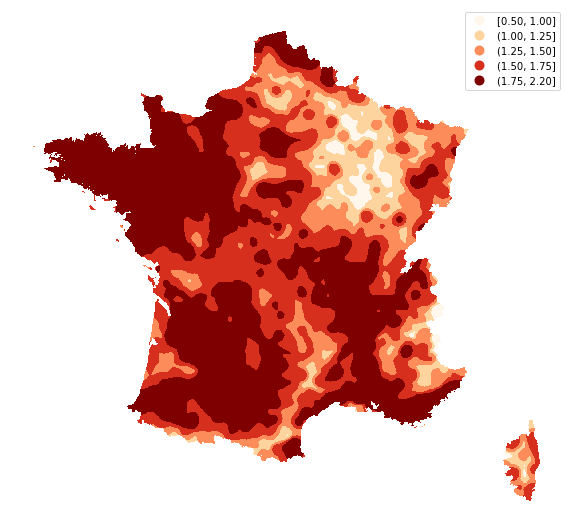

In [61]:
bins = [1, 1.25, 1.5, 1.75]
ax = scale_function_1.plot('D_1', scheme = 'User_Defined', classification_kwds={'bins':bins}, figsize=(10,10), legend=True, cmap='OrRd')
ax.axis(False)